In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math

In [2]:
df_list = []
for file in os.listdir('data/'):
    temp_df = pd.read_csv('data/'+file)
    temp_df['p_id'] = int(file[:3])
    df_list.append(temp_df)
df = pd.concat(df_list).reset_index().drop('index', axis = 1)

In [3]:
df

,target_x,target_y,repeat_instructions.thisRepN,repeat_instructions.thisTrialN,repeat_instructions.thisN,repeat_instructions.thisIndex,accuracy_instructions.thisRepN,accuracy_instructions.thisTrialN,accuracy_instructions.thisN,accuracy_instructions.thisIndex,...,instr_adv_mouse_3_spd.x,instr_adv_mouse_3_spd.y,instr_adv_mouse_3_spd.leftButton,instr_adv_mouse_3_spd.midButton,instr_adv_mouse_3_spd.rightButton,instr_adv_mouse_3_spd.time,phase_cntdown.stopped,Unnamed: 281,repeat_instr_repeat.rt,Unnamed: 282
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,-0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def clean_data(df):
    # Filter rows based on column: 'target_x'
    df = df[df['target_x'].notna()]
    # Filter rows based on column: 'rotated_blocks.thisN'
    df = df[df['rotated_blocks.thisN'].notna()]
    # Drop columns: 'repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN' and 273 other columns
    df = df.drop(columns=['repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN', 'repeat_instructions.thisN', 'repeat_instructions.thisIndex', 'accuracy_instructions.thisRepN', 'accuracy_instructions.thisTrialN', 'accuracy_instructions.thisN', 'accuracy_instructions.thisIndex', 'speed_instructions.thisRepN', 'speed_instructions.thisTrialN', 'speed_instructions.thisN', 'speed_instructions.thisIndex', 'aiming_trials.thisTrialN', 'aiming_trials.thisN', 'aiming_trials.thisIndex', 'unlearning_trials.thisRepN', 'unlearning_trials.thisTrialN', 'unlearning_trials.thisN', 'unlearning_trials.thisIndex', 'relearning_blocks.thisRepN', 'relearning_blocks.thisTrialN', 'relearning_blocks.thisN', 'relearning_blocks.thisIndex', 'relearning_trials.thisRepN', 'relearning_trials.thisTrialN', 'relearning_trials.thisN', 'relearning_trials.thisIndex', 'instr_adv_mouse_0.started', 'instr_adv_text_0.started', 'instr_adv_mouse_0.x', 'instr_adv_mouse_0.y', 'instr_adv_mouse_0.leftButton', 'instr_adv_mouse_0.midButton', 'instr_adv_mouse_0.rightButton', 'instr_adv_mouse_0.time', 'consent0.started', 'consent_text0.started', 'consent0_keyresp.started', 'consent0_keyresp.keys', 'consent0_keyresp.rt', 'consent_text1.started', 'consent1.started', 'consent1_keyresp.started', 'consent1_keyresp.keys', 'consent1_keyresp.rt', 'consent2.started', 'consent_text2.started', 'consent2_keyresp.started', 'consent2_keyresp.keys', 'consent2_keyresp.rt', 'consent_text3.started', 'consent3_keyresp.started', 'consent3.started', 'consent3_keyresp.keys', 'consent3_keyresp.rt', 'consent_text4.started', 'consent4_keyresp.started', 'consent4.started', 'consent4_keyresp.keys', 'consent4_keyresp.rt', 'agree.started', 'disagree.started', 'consent5.started', 'agree.numClicks', 'agree.timesOn', 'agree.timesOff', 'disagree.numClicks', 'disagree.timesOn', 'disagree.timesOff', 'age.started', 'respAge.started', 'gender.started', 'genderResp2.started', 'nextButton.started', 'mouse.started', 'respAge.response', 'respAge.rt', 'genderResp2.text', 'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'mouse.clicked_name', 'instr_adv_mouse_05.started', 'instr_adv_text_05.started', 'instr_adv_mouse_05.x', 'instr_adv_mouse_05.y', 'instr_adv_mouse_05.leftButton', 'instr_adv_mouse_05.midButton', 'instr_adv_mouse_05.rightButton', 'instr_adv_mouse_05.time', 'instr_adv_text_1.started', 'instr_adv_mouse_1.started', 'instr_adv_mouse_1.x', 'instr_adv_mouse_1.y', 'instr_adv_mouse_1.leftButton', 'instr_adv_mouse_1.midButton', 'instr_adv_mouse_1.rightButton', 'instr_adv_mouse_1.time', 'instr_adv_text_2.started', 'instr_adv_mouse_2.started', 'instr_adv_mouse_2.x', 'instr_adv_mouse_2.y', 'instr_adv_mouse_2.leftButton', 'instr_adv_mouse_2.midButton', 'instr_adv_mouse_2.rightButton', 'instr_adv_mouse_2.time', 'instr_acc_adv_text_3.started', 'instr_adv_mouse_3_acc.started', 'instr_adv_mouse_3_acc.x', 'instr_adv_mouse_3_acc.y', 'instr_adv_mouse_3_acc.leftButton', 'instr_adv_mouse_3_acc.midButton', 'instr_adv_mouse_3_acc.rightButton', 'instr_adv_mouse_3_acc.time', 'repeat_instructions_text.started', 'repeat_instr_adv.started', 'repeat_instr_repeat.started', 'repeat_instr_adv.x', 'repeat_instr_adv.y', 'repeat_instr_adv.leftButton', 'repeat_instr_adv.midButton', 'repeat_instr_adv.rightButton', 'repeat_instr_adv.time', 'repeat_instr_repeat.keys', 'text_countdown_2.started', 'cursor.started', 'cursor.stopped', 'target_baseline.started', 'mouse_baseline.started', 'cursor_baseline.started', 'target_baseline.stopped', 'mouse_baseline.stopped', 'cursor_baseline.stopped', 'mouse_baseline.leftButton', 'mouse_baseline.midButton', 'mouse_baseline.rightButton', 'mouse_baseline.time', 'mouse_baseline.clicked_name', 'break_text.started', 'break_mouse.started', 'improve_text.started', 'break_mouse.x', 'break_mouse.y', 'break_mouse.leftButton', 'break_mouse.midButton', 'break_mouse.rightButton', 'break_mouse.time', 'target_rotated.started', 'mouse_rotated.started', 'cursor_rotated.started', 'mouse_rotated.leftButton', 'mouse_rotated.midButton', 'mouse_rotated.rightButton', 'mouse_rotated.time', 'instr_adv_text_4.started', 'instr_adv_mouse_4.started', 'instr_adv_mouse_4.x', 'instr_adv_mouse_4.y', 'instr_adv_mouse_4.leftButton', 'instr_adv_mouse_4.midButton', 'instr_adv_mouse_4.rightButton', 'instr_adv_mouse_4.time', 'instr_adv_text_5.started', 'instr_adv_mouse_5.started', 'instr_adv_mouse_5.x', 'instr_adv_mouse_5.y', 'instr_adv_mouse_5.leftButton', 'instr_adv_mouse_5.midButton', 'instr_adv_mouse_5.rightButton', 'instr_adv_mouse_5.time', 'instr_adv_text_55.started', 'instr_adv_mouse_55.started', 'instr_adv_mouse_55.x', 'instr_adv_mouse_55.y', 'instr_adv_mouse_55.leftButton', 'instr_adv_mouse_55.midButton', 'instr_adv_mouse_55.rightButton', 'instr_adv_mouse_55.time', 'phase_cntdown.started', 'target_aiming.started', 'aim_typing_instruction.started', 'aim_report_text.started', 'end_routine_instruction.started', 'aim_cursor.started', 'aim_report_end.started', 'aim_report_text.text', 'aim_report_end.keys', 'aim_report_end.rt', 'target_swiping.started', 'swipe_cursor.started', 'aim_swipe_mouse.started', 'swiping_trial_instuctions.started', 'aim_swipe_mouse.x', 'aim_swipe_mouse.y', 'aim_swipe_mouse.leftButton', 'aim_swipe_mouse.midButton', 'aim_swipe_mouse.rightButton', 'aim_swipe_mouse.time', 'text.started', 'text.stopped', 'instr_adv_text_6.started', 'instr_adv_mouse_6.started', 'instr_adv_mouse_6.x', 'instr_adv_mouse_6.y', 'instr_adv_mouse_6.leftButton', 'instr_adv_mouse_6.midButton', 'instr_adv_mouse_6.rightButton', 'instr_adv_mouse_6.time', 'target_unlearning.started', 'mouse_unlearning.started', 'cursor_unlearning.started', 'mouse_unlearning.x', 'mouse_unlearning.y', 'mouse_unlearning.leftButton', 'mouse_unlearning.midButton', 'mouse_unlearning.rightButton', 'mouse_unlearning.time', 'no_score_break_text.started', 'no_score_break_mouse.started', 'no_score_break_mouse.x', 'no_score_break_mouse.y', 'no_score_break_mouse.leftButton', 'no_score_break_mouse.midButton', 'no_score_break_mouse.rightButton', 'no_score_break_mouse.time', 'study_done.started', 'study_done_mouse.started', 'thoughts_on_study.started', 'study_done_adv.started', 'study_done_mouse.x', 'study_done_mouse.y', 'study_done_mouse.leftButton', 'study_done_mouse.midButton', 'study_done_mouse.rightButton', 'study_done_mouse.time', 'thoughts_on_study.text', 'pre_debrief_text.started', 'pre_debrief_mouse.started', 'pre_debrief_mouse.x', 'pre_debrief_mouse.y', 'pre_debrief_mouse.leftButton', 'pre_debrief_mouse.midButton', 'pre_debrief_mouse.rightButton', 'pre_debrief_mouse.time', 'debrief_text.started', 'debrief_mouse.started', 'debrief_mouse.x', 'debrief_mouse.y', 'debrief_mouse.leftButton', 'debrief_mouse.midButton', 'debrief_mouse.rightButton', 'debrief_mouse.time', 'text_countdown.started', 'participant', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 280', 'aim report', 'instr_spd_adv_text_3.started', 'instr_adv_mouse_3_spd.started', 'instr_adv_mouse_3_spd.x', 'instr_adv_mouse_3_spd.y', 'instr_adv_mouse_3_spd.leftButton', 'instr_adv_mouse_3_spd.midButton', 'instr_adv_mouse_3_spd.rightButton', 'instr_adv_mouse_3_spd.time', 'phase_cntdown.stopped', 'Unnamed: 281', 'repeat_instr_repeat.rt', 'Unnamed: 282', 'aiming_trials.thisRepN', 'mouse_baseline.x', 'mouse_baseline.y'])
    # Drop column: 'mouse.x'
    df = df.drop(columns=['mouse.x'])
    # Drop column: 'mouse.y'
    df = df.drop(columns=['mouse.y'])
    # Drop columns: 'baseline_trials.thisRepN', 'baseline_trials.thisTrialN' and 2 other columns
    df = df.drop(columns=['baseline_trials.thisRepN', 'baseline_trials.thisTrialN', 'baseline_trials.thisN', 'baseline_trials.thisIndex'])
    # Drop columns: 'mouse_rotated.x', 'mouse_rotated.y'
    df = df.drop(columns=['mouse_rotated.x', 'mouse_rotated.y'])
    return df

df_clean = clean_data(df.copy()).reset_index().drop('index', axis=1)


In [5]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(v1, v2)
    ab_magnitudes = np.linalg.norm(v1)
    ac_magnitudes = np.linalg.norm(v2)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))

  return np.nanmean(np.degrees(angles))

In [33]:
def comp_avg_ang_error(traj):
    try:
        end_point = np.tile(traj[-1], len(traj) - 1).reshape((len(traj) - 1, 2))
        curr_point = np.array(traj[:-1])
        next_point = np.array(traj[1:])
        
        angles = find_angles(curr_point, end_point, next_point)
        return angles
    except:
        return np.NaN

In [39]:
def comp_init_ang_error(traj, proportion):
    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2)

    try:
        for cutoff_point in traj:
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = cutoff_point - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [41]:
errors = []
for traj in df_clean['cursor trajectory'].values:
    errors.append(comp_init_ang_error(ast.literal_eval(traj), 0.1))

C:\Users\tejas\AppData\Local\Temp\ipykernel_13056\1741256698.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
C:\Users\tejas\AppData\Local\Temp\ipykernel_13056\1741256698.py:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [42]:
df_clean['errors'] = errors

In [43]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_clean):
    # Replace gaps forward from the previous valid value in: 'errors'
    df_clean = df_clean.fillna({'errors': df_clean['errors'].ffill()})
    return df_clean

df_learn = clean_data(df_clean.copy())


In [44]:
df_learn['trial'] = np.tile(np.arange(64*7), 64)
df_learn['block'] = np.tile(np.repeat(np.arange(7), 64), 64)
df_learn.loc[df_learn['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_learn.loc[df_learn['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_learn.loc[df_learn['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_learn.loc[df_learn['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_learn.loc[df_learn['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_learn.loc[df_learn['p_id']%4 == 3, 'Emphasis'] = 'Speed'

df_learn = df_learn[df_learn['p_id'] != 640]

In [71]:
df_learn[['p_id', 'errors', 'trial', 'block', 'Rotation', 'Emphasis']].to_csv('learning_10pcutoff_errors', index=False)

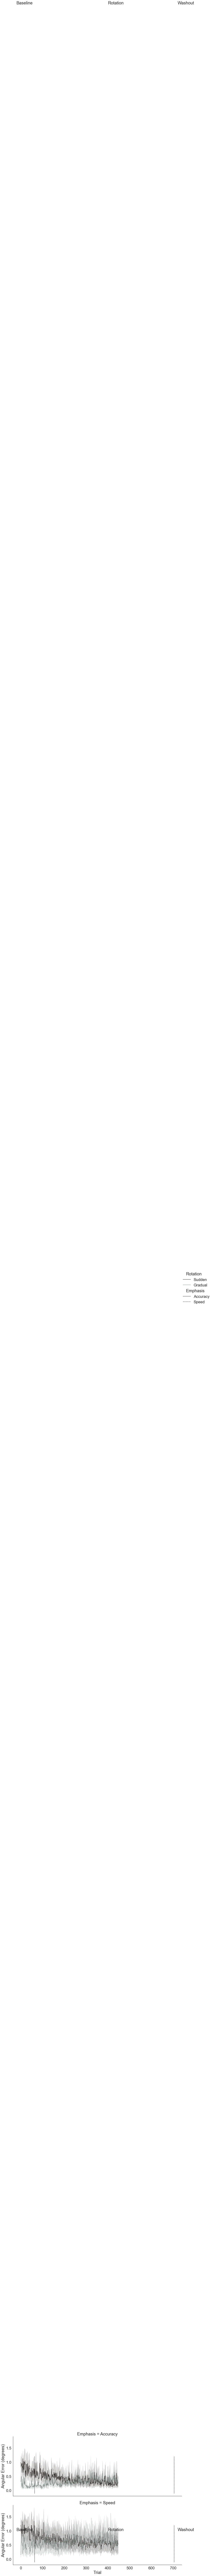

In [46]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial', y = 'errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_learn, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Angular Error (degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')

#plt.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#plt.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
plt.text(x = -20, y = 1, s = 'Baseline')
plt.text(x = 400, y = 1, s = 'Rotation')
plt.text(x = 720, y = 1, s = 'Washout')

plt.text(x = -20, y = 90, s = 'Baseline')
plt.text(x = 400, y = 90, s = 'Rotation')
plt.text(x = 720, y = 90, s = 'Washout')

sns.despine(bottom=False, left=False)

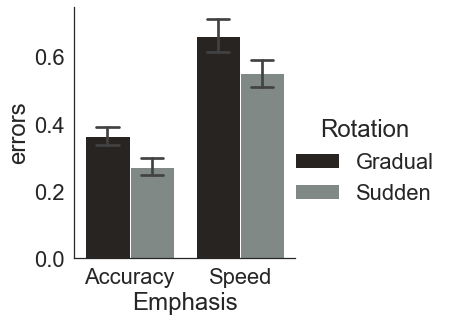

In [47]:
sns.catplot(x = 'Emphasis', y = 'errors', hue = 'Rotation', 
            data=df_learn.loc[df_learn['block'] == 6], kind = 'bar', capsize = 0.2)

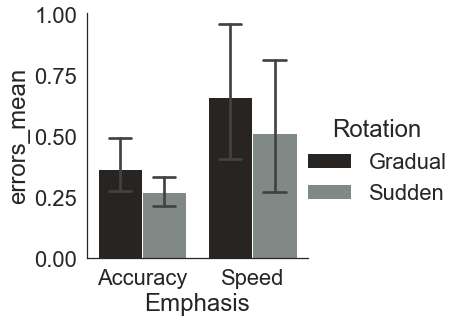

In [48]:
def clean_data_finalblock(df_learn):
    # Filter rows based on column: 'block'
    df_learn = df_learn[df_learn['block'] == 6]
    # Performed 1 aggregation grouped on columns: 'p_id', 'Rotation', 'Emphasis'
    df_learn = df_learn.groupby(['p_id', 'Rotation', 'Emphasis']).agg(errors_mean=('errors', 'mean')).reset_index()
    return df_learn

df_learn_finalblock = clean_data_finalblock(df_learn.copy())
sns.catplot(x = 'Emphasis', y = 'errors_mean', hue = 'Rotation', 
            data=df_learn_finalblock, kind = 'bar', capsize = 0.2)

In [49]:
def clean_data_aim(df):
    # Drop columns: 'repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN' and 281 other columns
    df = df.drop(columns=['repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN', 'repeat_instructions.thisN', 'repeat_instructions.thisIndex', 'accuracy_instructions.thisRepN', 'accuracy_instructions.thisTrialN', 'accuracy_instructions.thisN', 'accuracy_instructions.thisIndex', 'speed_instructions.thisRepN', 'speed_instructions.thisTrialN', 'speed_instructions.thisN', 'speed_instructions.thisIndex', 'baseline_trials.thisRepN', 'baseline_trials.thisTrialN', 'baseline_trials.thisN', 'baseline_trials.thisIndex', 'rotated_blocks.thisRepN', 'rotated_blocks.thisTrialN', 'rotated_blocks.thisN', 'rotated_blocks.thisIndex', 'rotated_trials.thisRepN', 'rotated_trials.thisTrialN', 'rotated_trials.thisN', 'rotated_trials.thisIndex', 'unlearning_trials.thisTrialN', 'unlearning_trials.thisN', 'unlearning_trials.thisIndex', 'relearning_blocks.thisRepN', 'relearning_blocks.thisTrialN', 'relearning_blocks.thisN', 'relearning_blocks.thisIndex', 'relearning_trials.thisRepN', 'relearning_trials.thisTrialN', 'relearning_trials.thisN', 'relearning_trials.thisIndex', 'instr_adv_mouse_0.started', 'instr_adv_text_0.started', 'instr_adv_mouse_0.x', 'instr_adv_mouse_0.y', 'instr_adv_mouse_0.leftButton', 'instr_adv_mouse_0.midButton', 'instr_adv_mouse_0.rightButton', 'instr_adv_mouse_0.time', 'consent0.started', 'consent_text0.started', 'consent0_keyresp.started', 'consent0_keyresp.keys', 'consent0_keyresp.rt', 'consent_text1.started', 'consent1.started', 'consent1_keyresp.started', 'consent1_keyresp.keys', 'consent1_keyresp.rt', 'consent2.started', 'consent_text2.started', 'consent2_keyresp.started', 'consent2_keyresp.keys', 'consent2_keyresp.rt', 'consent_text3.started', 'consent3_keyresp.started', 'consent3.started', 'consent3_keyresp.keys', 'consent3_keyresp.rt', 'consent_text4.started', 'consent4_keyresp.started', 'consent4.started', 'consent4_keyresp.keys', 'consent4_keyresp.rt', 'agree.started', 'disagree.started', 'consent5.started', 'agree.numClicks', 'agree.timesOn', 'agree.timesOff', 'disagree.numClicks', 'disagree.timesOn', 'disagree.timesOff', 'age.started', 'respAge.started', 'gender.started', 'genderResp2.started', 'nextButton.started', 'mouse.started', 'respAge.response', 'respAge.rt', 'genderResp2.text', 'mouse.x', 'mouse.y', 'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'mouse.clicked_name', 'instr_adv_mouse_05.started', 'instr_adv_text_05.started', 'instr_adv_mouse_05.x', 'instr_adv_mouse_05.y', 'instr_adv_mouse_05.leftButton', 'instr_adv_mouse_05.midButton', 'instr_adv_mouse_05.rightButton', 'instr_adv_mouse_05.time', 'instr_adv_text_1.started', 'instr_adv_mouse_1.started', 'instr_adv_mouse_1.x', 'instr_adv_mouse_1.y', 'instr_adv_mouse_1.leftButton', 'instr_adv_mouse_1.midButton', 'instr_adv_mouse_1.rightButton', 'instr_adv_mouse_1.time', 'instr_adv_text_2.started', 'instr_adv_mouse_2.started', 'instr_adv_mouse_2.x', 'instr_adv_mouse_2.y', 'instr_adv_mouse_2.leftButton', 'instr_adv_mouse_2.midButton', 'instr_adv_mouse_2.rightButton', 'instr_adv_mouse_2.time', 'instr_acc_adv_text_3.started', 'instr_adv_mouse_3_acc.started', 'instr_adv_mouse_3_acc.x', 'instr_adv_mouse_3_acc.y', 'instr_adv_mouse_3_acc.leftButton', 'instr_adv_mouse_3_acc.midButton', 'instr_adv_mouse_3_acc.rightButton', 'instr_adv_mouse_3_acc.time', 'repeat_instructions_text.started', 'repeat_instr_adv.started', 'repeat_instr_repeat.started', 'repeat_instr_adv.x', 'repeat_instr_adv.y', 'repeat_instr_adv.leftButton', 'repeat_instr_adv.midButton', 'repeat_instr_adv.rightButton', 'repeat_instr_adv.time', 'repeat_instr_repeat.keys', 'text_countdown_2.started', 'cursor.started', 'cursor.stopped', 'target_baseline.started', 'mouse_baseline.started', 'cursor_baseline.started', 'target_baseline.stopped', 'mouse_baseline.stopped', 'cursor_baseline.stopped', 'mouse_baseline.x', 'mouse_baseline.y', 'mouse_baseline.leftButton', 'mouse_baseline.midButton', 'mouse_baseline.rightButton', 'mouse_baseline.time', 'mouse_baseline.clicked_name', 'break_text.started', 'break_mouse.started', 'improve_text.started', 'break_mouse.x', 'break_mouse.y', 'break_mouse.leftButton', 'break_mouse.midButton', 'break_mouse.rightButton', 'break_mouse.time', 'target_rotated.started', 'mouse_rotated.started', 'cursor_rotated.started', 'mouse_rotated.x', 'mouse_rotated.y', 'mouse_rotated.leftButton', 'mouse_rotated.midButton', 'mouse_rotated.rightButton', 'mouse_rotated.time', 'instr_adv_text_4.started', 'instr_adv_mouse_4.started', 'instr_adv_mouse_4.x', 'instr_adv_mouse_4.y', 'instr_adv_mouse_4.leftButton', 'instr_adv_mouse_4.midButton', 'instr_adv_mouse_4.rightButton', 'instr_adv_mouse_4.time', 'instr_adv_text_5.started', 'instr_adv_mouse_5.started', 'instr_adv_mouse_5.x', 'instr_adv_mouse_5.y', 'instr_adv_mouse_5.leftButton', 'instr_adv_mouse_5.midButton', 'instr_adv_mouse_5.rightButton', 'instr_adv_mouse_5.time', 'instr_adv_text_55.started', 'instr_adv_mouse_55.started', 'instr_adv_mouse_55.x', 'instr_adv_mouse_55.y', 'instr_adv_mouse_55.leftButton', 'instr_adv_mouse_55.midButton', 'instr_adv_mouse_55.rightButton', 'instr_adv_mouse_55.time', 'phase_cntdown.started', 'target_aiming.started', 'aim_typing_instruction.started', 'end_routine_instruction.started', 'aim_cursor.started', 'aim_report_end.started', 'aim_report_end.keys', 'aim_report_end.rt', 'target_swiping.started', 'swipe_cursor.started', 'aim_swipe_mouse.started', 'swiping_trial_instuctions.started', 'aim_swipe_mouse.leftButton', 'aim_swipe_mouse.midButton', 'aim_swipe_mouse.rightButton', 'aim_swipe_mouse.time', 'text.started', 'text.stopped', 'instr_adv_text_6.started', 'instr_adv_mouse_6.started', 'instr_adv_mouse_6.x', 'instr_adv_mouse_6.y', 'instr_adv_mouse_6.leftButton', 'instr_adv_mouse_6.midButton', 'instr_adv_mouse_6.rightButton', 'instr_adv_mouse_6.time', 'target_unlearning.started', 'mouse_unlearning.started', 'cursor_unlearning.started', 'mouse_unlearning.x', 'mouse_unlearning.y', 'mouse_unlearning.leftButton', 'mouse_unlearning.midButton', 'mouse_unlearning.rightButton', 'mouse_unlearning.time', 'no_score_break_text.started', 'no_score_break_mouse.started', 'no_score_break_mouse.x', 'no_score_break_mouse.y', 'no_score_break_mouse.leftButton', 'no_score_break_mouse.midButton', 'no_score_break_mouse.rightButton', 'no_score_break_mouse.time', 'study_done.started', 'study_done_mouse.started', 'thoughts_on_study.started', 'study_done_adv.started', 'study_done_mouse.x', 'study_done_mouse.y', 'study_done_mouse.leftButton', 'study_done_mouse.midButton', 'study_done_mouse.rightButton', 'study_done_mouse.time', 'thoughts_on_study.text', 'pre_debrief_text.started', 'pre_debrief_mouse.started', 'pre_debrief_mouse.x', 'pre_debrief_mouse.y', 'pre_debrief_mouse.leftButton', 'pre_debrief_mouse.midButton', 'pre_debrief_mouse.rightButton', 'pre_debrief_mouse.time', 'debrief_text.started', 'debrief_mouse.started', 'debrief_mouse.x', 'debrief_mouse.y', 'debrief_mouse.leftButton', 'debrief_mouse.midButton', 'debrief_mouse.rightButton', 'debrief_mouse.time', 'text_countdown.started', 'participant', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 280', 'instr_spd_adv_text_3.started', 'instr_adv_mouse_3_spd.started', 'instr_adv_mouse_3_spd.x', 'instr_adv_mouse_3_spd.y', 'instr_adv_mouse_3_spd.leftButton', 'instr_adv_mouse_3_spd.midButton', 'instr_adv_mouse_3_spd.rightButton', 'instr_adv_mouse_3_spd.time', 'phase_cntdown.stopped', 'Unnamed: 281', 'repeat_instr_repeat.rt', 'Unnamed: 282', 'unlearning_trials.thisRepN', 'aim_report_text.started'])
    # Filter rows based on column: 'aim_swipe_mouse.x'
    df = df[df['aim_swipe_mouse.x'].notna()]
    # Filter rows based on column: 'aim report'
    df = df[df['aim report'].notna()]
    # Drop column: 'aim_report_text.text'
    df = df.drop(columns=['aim_report_text.text'])
    # Drop column: 'cursor trajectory'
    df = df.drop(columns=['cursor trajectory'])
    return df

df_aim = clean_data_aim(df.copy()).reset_index().drop('index', axis = 1)
# df_aim.head()

In [50]:
def find_aim_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  dotprod = np.dot(ab, ac)
  ab_magnitudes = np.linalg.norm(ab)
  ac_magnitudes = np.linalg.norm(ac)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))

  return np.degrees(angles)

In [51]:
aim_swipe_error = []
for i in range(len(df_aim)):
    x_target = df_aim.loc[i, 'target_x']
    y_target = df_aim.loc[i, 'target_y']
    x_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.x'])[-1]
    y_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.y'])[-1]

    swipe_angle = find_aim_angles(np.array([0, 0]), np.array([1, 0]), np.array([x_end, y_end]))/4
    report_angle = df_aim.loc[i, 'aim report']
    aim_swipe_error.append(report_angle - swipe_angle)
df_aim['aim report - swipe'] = aim_swipe_error

C:\Users\tejas\AppData\Local\Temp\ipykernel_13056\173691674.py:12: RuntimeWarning: invalid value encountered in double_scalars
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))


In [52]:
df_aim['trial'] = np.tile(np.arange(16), 63)
df_aim.loc[df_aim['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_aim.loc[df_aim['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_aim.loc[df_aim['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_aim.loc[df_aim['p_id']%4 == 3, 'Emphasis'] = 'Speed'

df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 45/4
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 135/4
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 225/4
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 315/4

df_aim['optimal aim'] = df_aim['target angle'] + 60/4
df_aim.loc[df_aim['optimal aim'] > 90, 'optimal aim'] = 90 - df_aim.loc[df_aim['optimal aim'] < 0, 'optimal aim'] 
df_aim['aim optim - report'] = df_aim['optimal aim'] - df_aim['aim report']
df_aim['aim optim - swipe'] = df_aim['optimal aim'] - (df_aim['aim report'] - df_aim['aim report - swipe'])

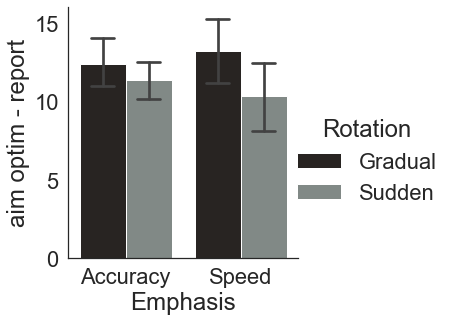

In [53]:
sns.catplot(hue = 'Rotation', y = 'aim optim - report', x = 'Emphasis', 
            kind = 'bar', capsize = 0.2,
            data = df_aim)

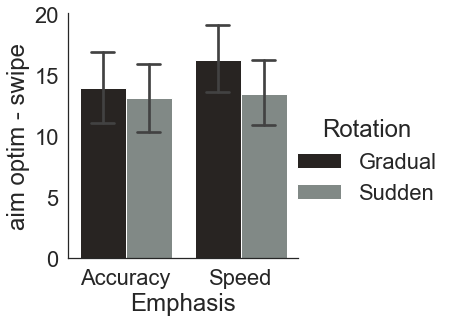

In [54]:
sns.catplot(hue = 'Rotation', y = 'aim optim - swipe', x = 'Emphasis', 
            kind = 'bar', capsize = 0.2,
            data = df_aim)

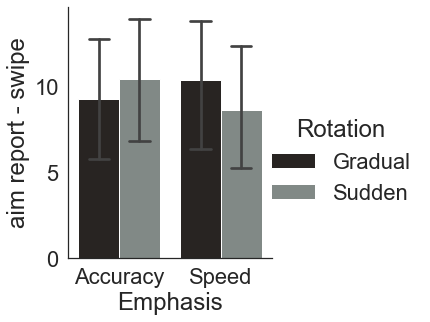

In [56]:
sns.catplot(hue = 'Rotation', y = 'aim report - swipe', x = 'Emphasis', 
            kind = 'bar', capsize = 0.2,
            data = df_aim)

In [61]:
df_learn_finalblock

,p_id,Rotation,Emphasis,errors_mean
0,641,Gradual,Accuracy,0.175540
1,642,Sudden,Speed,1.059229
2,643,Gradual,Speed,0.403212
3,644,Sudden,Accuracy,0.443197
4,645,Gradual,Accuracy,0.144246
...,...,...,...,...
57,698,Sudden,Speed,0.176245
58,699,Gradual,Speed,0.219368
59,700,Sudden,Accuracy,0.210795
60,701,Gradual,Accuracy,0.222786


In [62]:
df_aim['final block errors'] = 0
for participant in df_aim.p_id:
    df_aim.loc[df_aim['p_id'] == participant, 'final block errors'] = df_learn_finalblock.loc[df_learn_finalblock['p_id'] == participant, 'errors_mean'].values[0]

In [66]:
df_aim['aim report - final block rotation'] = df_aim['aim report'] - (np.pi/3 - df_aim['final block errors'])

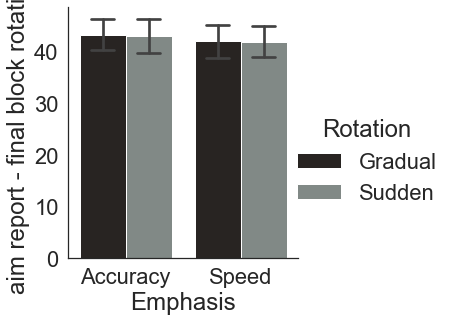

In [67]:
sns.catplot(x = 'Emphasis', y = 'aim report - final block rotation', hue = 'Rotation', 
            data=df_aim, kind = 'bar', capsize = 0.2)

In [281]:
df_learn

,target_x,target_y,rotated_blocks.thisRepN,rotated_blocks.thisTrialN,rotated_blocks.thisN,rotated_blocks.thisIndex,rotated_trials.thisRepN,rotated_trials.thisTrialN,rotated_trials.thisN,rotated_trials.thisIndex,cursor trajectory,p_id,errors,trial,block,Rotation,Emphasis
448,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,"[(0.0, 0.0), (-0.0036474361222674423, 0.000643...",641,15.866842,0,0,Gradual,Accuracy
449,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,[],641,15.866842,1,0,Gradual,Accuracy
450,0.3,0.3,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,"[(0.0, 0.0), (0.012497308796135554, 0.00155722...",641,8.380007,2,0,Gradual,Accuracy
451,0.3,-0.3,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,"[(0.0, 0.0), (0.004722306649469252, -0.0158760...",641,15.639499,3,0,Gradual,Accuracy
452,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,4.0,4.0,11.0,"[(0.0, 0.0), (-0.020005819457944836, -0.006814...",641,33.732025,4,0,Gradual,Accuracy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28667,0.3,0.3,6.0,0.0,6.0,0.0,3.0,11.0,59.0,8.0,"[(0.0, 0.0), (0.011383545031536987, -0.0030502...",702,35.197463,443,6,Sudden,Speed
28668,0.3,-0.3,6.0,0.0,6.0,0.0,3.0,12.0,60.0,13.0,"[(0.0, 0.0), (0.00921711358509661, 0.019220676...",702,17.797555,444,6,Sudden,Speed
28669,-0.3,0.3,6.0,0.0,6.0,0.0,3.0,13.0,61.0,2.0,"[(0.0, 0.0), (0.020633897861876412, 0.00870548...",702,38.520641,445,6,Sudden,Speed
28670,-0.3,-0.3,6.0,0.0,6.0,0.0,3.0,14.0,62.0,11.0,"[(0.0, 0.0), (0.0299263963663785, -0.014797001...",702,41.061875,446,6,Sudden,Speed
